<a href="https://colab.research.google.com/github/NeDa-Y/OpenCV-Python/blob/master/AC_trader_for_PG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Actor Critic for IBM


In [ ]:
import pkg_resources
import pip
installedPackages = {pkg.key for pkg in pkg_resources.working_set}
required = {'yfinance', 'pandas', 'matplotlib', 'stockstats','stable-baselines','gym','tensorflow'}
missing = required - installedPackages
if missing:
    !pip install yfinance
    !pip install pandas
    !pip install matplotlib
    !pip install stockstats
    !pip install gym
    !pip install stable-baselines[mpi]
    !pip install tensorflow==1.15.4


In [ ]:
import yfinance as yf
from stockstats import StockDataFrame as Sdf

import pandas as pd
import matplotlib.pyplot as plt

import gym
from stable_baselines import A2C, ACKTR
from stable_baselines.common.vec_env import DummyVecEnv
from stable_baselines.common.policies import MlpPolicy

import numpy as np
import pandas as pd
from gym.utils import seeding
import gym
from gym import spaces
import matplotlib
matplotlib.use('Agg')

#Diable the warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Download and save the data in a pandas DataFrame:
data_df = yf.download("PG", start="2009-01-01", end="2021-03-12")

[*********************100%***********************]  1 of 1 completed


In [ ]:
data_df.shape

(3068, 6)

In [ ]:
# reset the index, we want to use numbers instead of dates
data_df=data_df.reset_index()

In [ ]:
data_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2009-01-02,61.689999,62.970001,61.060001,62.799999,43.101299,11135700
1,2009-01-05,62.320000,62.439999,61.590000,62.349998,42.792446,14322800
2,2009-01-06,62.500000,62.950001,61.509998,62.169998,42.668911,13401600
3,2009-01-07,61.330002,61.660000,60.639999,61.080002,41.920818,12415600
4,2009-01-08,60.910000,61.250000,60.000000,60.410000,41.460972,11508100


In [ ]:
data_df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [ ]:
# convert the column names to standardized names
data_df.columns = ['datadate','open','high','low','close','adjcp','volume']

In [ ]:
# check missing data 
data_df.isnull().values.any()

False

In [ ]:
stock = Sdf.retype(data_df.copy())
# we need to use adjusted close price instead of close price
stock['close'] = stock['adjcp']


In [ ]:
data_df.head()

,datadate,open,high,low,close,adjcp,volume
0,2009-01-02,61.689999,62.970001,61.060001,62.799999,43.101299,11135700
1,2009-01-05,62.320000,62.439999,61.590000,62.349998,42.792446,14322800
2,2009-01-06,62.500000,62.950001,61.509998,62.169998,42.668911,13401600
3,2009-01-07,61.330002,61.660000,60.639999,61.080002,41.920818,12415600
4,2009-01-08,60.910000,61.250000,60.000000,60.410000,41.460972,11508100


In [ ]:
# Make a copy of the original data to try it track step by step.
data_clean = data_df.copy()

In [ ]:
data_clean.head()

,datadate,open,high,low,close,adjcp,volume
0,2009-01-02,61.689999,62.970001,61.060001,62.799999,43.101299,11135700
1,2009-01-05,62.320000,62.439999,61.590000,62.349998,42.792446,14322800
2,2009-01-06,62.500000,62.950001,61.509998,62.169998,42.668911,13401600
3,2009-01-07,61.330002,61.660000,60.639999,61.080002,41.920818,12415600
4,2009-01-08,60.910000,61.250000,60.000000,60.410000,41.460972,11508100


In [ ]:
# Global variables
HMAX_NORMALIZE = 200
INITIAL_ACCOUNT_BALANCE=100000
STOCK_DIM = 1

# transaction fee: 1/1000 reasonable percentage
TRANSACTION_FEE_PERCENT = 0
# REWARD_SCALING = 1e-3

In [ ]:
class SingleStockEnv(gym.Env):
    """A stock trading environment for OpenAI gym"""
    metadata = {'render.modes': ['human']}

    def __init__(self, df,day = 0):
        #super(StockEnv, self).__init__()
        # date increment
        self.day = day
        self.df = df
        # action_space normalization and the shape is STOCK_DIM
        self.action_space = spaces.Box(low = -1, high = 1,shape = (STOCK_DIM,)) 
        # Shape = 4: [Current Balance]+[prices]+[owned shares] +[macd] 
        self.observation_space = spaces.Box(low=0, high=np.inf, shape = (3,))
        # load data from a pandas dataframe
        self.data = self.df.loc[self.day,:]
        # termination
        self.terminal = False  
        # save the total number of trades
        self.trades = 0
        # initalize state
        self.state = [INITIAL_ACCOUNT_BALANCE] + \
                      [self.data.adjcp] + \
                      [0]*STOCK_DIM 
        # initialize reward and cost
        self.reward = 0
        self.cost = 0
        
        # memorize the total value, total rewards
        self.asset_memory = [INITIAL_ACCOUNT_BALANCE]
        self.rewards_memory = []

    def _sell_stock(self, index, action):
        # perform sell action based on the sign of the action
        if self.state[index+STOCK_DIM+1] > 0:
            # update balance
            self.state[0] += \
            self.state[index+1]*min(abs(action),self.state[index+STOCK_DIM+1]) * \
             (1- TRANSACTION_FEE_PERCENT)
            # update held shares
            self.state[index+STOCK_DIM+1] -= min(abs(action), self.state[index+STOCK_DIM+1])
            # update transaction costs
            self.cost +=self.state[index+1]*min(abs(action),self.state[index+STOCK_DIM+1]) * \
             TRANSACTION_FEE_PERCENT
            self.trades+=1
        else:
            pass
            
    def _buy_stock(self, index, action):
        # perform buy action based on the sign of the action
        available_amount = self.state[0] // self.state[index+1]
        #update balance
        self.state[0] -= self.state[index+1]*min(available_amount, action)* \
                          (1+ TRANSACTION_FEE_PERCENT)
        # update held shares
        self.state[index+STOCK_DIM+1] += min(available_amount, action)
        # update transaction costs
        self.cost+=self.state[index+1]*min(available_amount, action)* \
                          TRANSACTION_FEE_PERCENT
        self.trades+=1
        
    def step(self, actions):
        self.terminal = self.day >= len(self.df.index.unique())-1

        if self.terminal:
            plt.plot(self.asset_memory,'r')
            plt.savefig('account_value.png')
            plt.close()
            
            end_total_asset = self.state[0]+ \
            sum(np.array(self.state[1:(STOCK_DIM+1)])*np.array(self.state[(STOCK_DIM+1):(STOCK_DIM*2+1)]))
            print("previous_total_asset:{}".format(self.asset_memory[0])) 
            print("end_total_asset:{}".format(end_total_asset))
            
            df_total_value = pd.DataFrame(self.asset_memory)
            df_total_value.to_csv('account_value.csv')
            print("total_reward:{}".format(self.state[0]+sum(np.array(self.state[1:(STOCK_DIM+1)])*np.array(self.state[(STOCK_DIM+1):(STOCK_DIM*2+1)]))- INITIAL_ACCOUNT_BALANCE ))
            print("total_cost: ", self.cost)
            print("total trades: ", self.trades)
            
            df_total_value.columns = ['account_value']
            df_total_value['daily_return']=df_total_value.pct_change(1)
            
            if df_total_value['daily_return'].std()!=0:
                sharpe = (252**0.5)*df_total_value['daily_return'].mean()/ \
                      df_total_value['daily_return'].std()
                print("Sharpe: ",sharpe)
            df_rewards = pd.DataFrame(self.rewards_memory)
            df_rewards.to_csv('account_rewards.csv')
            return self.state, self.reward, self.terminal,{}

        else:
            
            # actions are the shares we need to buy, hold, or sell
            actions = actions * HMAX_NORMALIZE
            # calculate begining total asset
            begin_total_asset = self.state[0]+ \
            sum(np.array(self.state[1:(STOCK_DIM+1)])*np.array(self.state[(STOCK_DIM+1):(STOCK_DIM*2+1)]))
            
            # perform buy or sell action
            argsort_actions = np.argsort(actions)
            sell_index = argsort_actions[:np.where(actions < 0)[0].shape[0]]
            buy_index = argsort_actions[::-1][:np.where(actions > 0)[0].shape[0]]

            for index in sell_index:
                # print('take sell action'.format(actions[index]))
                self._sell_stock(index, actions[index])

            for index in buy_index:
                # print('take buy action: {}'.format(actions[index]))
                self._buy_stock(index, actions[index])
            
            # update data, walk a step s'
            self.day += 1
            self.data = self.df.loc[self.day,:]         
            #load next state
            self.state =  [self.state[0]] + \
                          [self.data.adjcp] + \
                          list(self.state[(STOCK_DIM+1):(STOCK_DIM*2+1)]) 
                        
            # calculate the end total asset
            end_total_asset = self.state[0]+ \
            sum(np.array(self.state[1:(STOCK_DIM+1)])*np.array(self.state[(STOCK_DIM+1):(STOCK_DIM*2+1)]))
            self.reward = end_total_asset - begin_total_asset  
            self.rewards_memory.append(self.reward)
            #self.reward = self.reward * REWARD_SCALING
            self.asset_memory.append(end_total_asset)

        return self.state, self.reward, self.terminal, {}

    def reset(self):
        self.asset_memory = [INITIAL_ACCOUNT_BALANCE]
        self.day = 0
        self.data = self.df.loc[self.day,:]
        self.cost = 0
        self.trades = 0
        self.terminal = False 
        self.rewards_memory = []
        #initiate state
        self.state = [INITIAL_ACCOUNT_BALANCE] + \
                      [self.data.adjcp] + \
                      [0]*STOCK_DIM 
        return self.state
    
    def render(self, mode='human'):
        return self.state

    def _seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

In [ ]:
(80/100)*3076

2460.8

In [ ]:
train = data_clean[(data_clean.datadate>='2009-01-01') & (data_clean.datadate<'2019-01-01')]
# the index needs to start from 0
train=train.reset_index(drop=True)


In [ ]:
train.tail()

,datadate,open,high,low,close,adjcp,volume
2511,2018-12-24,90.449997,90.660004,86.879997,87.360001,82.425110,7396300
2512,2018-12-26,87.419998,90.089996,86.739998,90.089996,85.000893,8630900
2513,2018-12-27,89.610001,92.050003,88.199997,92.019997,86.821861,11360100
2514,2018-12-28,92.559998,93.279999,90.839996,91.180000,86.029327,9611800
2515,2018-12-31,91.629997,92.180000,91.150002,91.919998,86.727516,7239500


Model Training

In [ ]:
#tensorboard --logdir ./single_stock_tensorboard/
env_train = DummyVecEnv([lambda: SingleStockEnv(train)])
model_a2c = A2C('MlpPolicy', env_train, tensorboard_log="./single_stock_trading_2_tensorboard/")
model_a2c.learn(total_timesteps=100000,tb_log_name="run_pg1_a2c")
#model.save('PG_pg1_50k')

previous_total_asset:100000
end_total_asset:153939.61495206377
total_reward:53939.61495206377
total_cost:  0.0
total trades:  2436
Sharpe:  0.549185896177876
previous_total_asset:100000
end_total_asset:146464.42886527546
total_reward:46464.42886527546
total_cost:  0.0
total trades:  2266
Sharpe:  0.439979661013481
previous_total_asset:100000
end_total_asset:176474.9790727289
total_reward:76474.9790727289
total_cost:  0.0
total trades:  2358
Sharpe:  0.6528767889542381
previous_total_asset:100000
end_total_asset:145747.7471390214
total_reward:45747.747139021405
total_cost:  0.0
total trades:  2356
Sharpe:  0.4520307481217567
previous_total_asset:100000
end_total_asset:224648.65682740923
total_reward:124648.65682740923
total_cost:  0.0
total trades:  2513
Sharpe:  0.6150101410628456
previous_total_asset:100000
end_total_asset:220468.29124371195
total_reward:120468.29124371195
total_cost:  0.0
total trades:  2513
Sharpe:  0.6115563642903663
previous_total_asset:100000
end_total_asset:2181

In [ ]:
#tensorboard --logdir ./single_stock_tensorboard/
env_train = DummyVecEnv([lambda: SingleStockEnv(train)])
model_acktr = ACKTR('MlpPolicy', env_train, tensorboard_log="./single_stock_trading_2_tensorboard/")
model_acktr.learn(total_timesteps=100000,tb_log_name="run_pg2_acktr")
#model.save('PG_pg2_50k')

previous_total_asset:100000
end_total_asset:126030.49900805681
total_reward:26030.49900805681
total_cost:  0.0
total trades:  2461
Sharpe:  0.35162800234272135
previous_total_asset:100000
end_total_asset:139822.5558512727
total_reward:39822.555851272686
total_cost:  0.0
total trades:  2492
Sharpe:  0.41015640043003226
previous_total_asset:100000
end_total_asset:127200.5236836455
total_reward:27200.5236836455
total_cost:  0.0
total trades:  2458
Sharpe:  0.34496432484218087
previous_total_asset:100000
end_total_asset:181748.7380768367
total_reward:81748.73807683669
total_cost:  0.0
total trades:  2447
Sharpe:  0.6885671841286156
previous_total_asset:100000
end_total_asset:120636.72446971454
total_reward:20636.724469714536
total_cost:  0.0
total trades:  2409
Sharpe:  0.2452114770693998
previous_total_asset:100000
end_total_asset:149179.1163974743
total_reward:49179.11639747431
total_cost:  0.0
total trades:  2435
Sharpe:  0.5559354833917152
previous_total_asset:100000
end_total_asset:14

Testing data

In [ ]:
test = data_clean[(data_clean.datadate>='2019-01-01') ]
# the index needs to start from 0
test=test.reset_index(drop=True)

In [ ]:
test.head()

,datadate,open,high,low,close,adjcp,volume
0,2019-01-02,91.029999,91.389999,89.930000,91.279999,86.123672,9843900
1,2019-01-03,90.940002,92.500000,90.379997,90.639999,85.519829,9820200
2,2019-01-04,90.839996,92.489998,90.370003,92.489998,87.265327,10565700
3,2019-01-07,91.910004,92.500000,91.400002,92.120003,86.916237,9012500
4,2019-01-08,92.699997,93.089996,91.820000,92.459999,87.237015,9551300


In [ ]:
test.tail()

,datadate,open,high,low,close,adjcp,volume
547,2021-03-05,122.760002,126.330002,122.550003,125.980003,125.980003,10490900
548,2021-03-08,125.760002,128.899994,125.320000,127.309998,127.309998,9223200
549,2021-03-09,127.650002,128.919998,126.059998,126.180000,126.180000,8859300
550,2021-03-10,126.150002,128.419998,125.470001,127.339996,127.339996,9070400
551,2021-03-11,127.129997,127.849998,126.720001,126.910004,126.910004,6941500


Trading For Test Data

In [ ]:
model = model_acktr
env_test = DummyVecEnv([lambda: SingleStockEnv(test)])
obs_test = env_test.reset()
print("==============Model Prediction===========")
for i in range(len(test.index.unique())):
    action, _states = model.predict(obs_test)
    obs_test, rewards, dones, info = env_test.step(action)
    env_test.render()

==============Model Prediction===========
previous_total_asset:100000
end_total_asset:125267.5542324994
total_reward:25267.554232499402
total_cost:  0.0
total trades:  463
Sharpe:  1.230700401788404


In [ ]:
model = model_a2c
env_test = DummyVecEnv([lambda: SingleStockEnv(test)])
obs_test = env_test.reset()
print("==============Model Prediction===========")
for i in range(len(test.index.unique())):
    action, _states = model.predict(obs_test)
    obs_test, rewards, dones, info = env_test.step(action)
    env_test.render()

==============Model Prediction===========
previous_total_asset:100000
end_total_asset:141337.7156586974
total_reward:41337.71565869739
total_cost:  0.0
total trades:  551
Sharpe:  0.7734344119529032


Backtest Our Strategy

In [ ]:
def get_DRL_sharpe():
    df_total_value=pd.read_csv('account_value.csv',index_col=0)
    df_total_value.columns = ['account_value']
    df_total_value['daily_return']=df_total_value.pct_change(1)
    sharpe = (252**0.5)*df_total_value['daily_return'].mean()/ \
    df_total_value['daily_return'].std()
    
    annual_return = ((df_total_value['daily_return'].mean()+1)**252-1)*100
    print("annual return: ", annual_return)
    print("sharpe ratio: ", sharpe)
    return df_total_value

In [ ]:
def get_test_sharpe(test):
    test['daily_return']=test['adjcp'].pct_change(1)
    sharpe = (252**0.5)*test['daily_return'].mean()/ \
    test['daily_return'].std()
    annual_return = ((test['daily_return'].mean()+1)**252-1)*100
    print("annual return: ", annual_return)

    print("sharpe ratio: ", sharpe)
    #return sharpe

In [ ]:
df_total_value=get_DRL_sharpe()

annual return:  20.63336413792054
sharpe ratio:  0.773434411952904


In [ ]:
get_test_sharpe(test)

annual return:  23.22098770295846
sharpe ratio:  0.8298425250574434


In [ ]:
DRL_cumulative_return = (df_total_value.account_value.pct_change(1)+1).cumprod()-1

In [ ]:
test_cumulative_return = (test.adjcp.pct_change(1)+1).cumprod()-1

In [ ]:
DRL_cumulative_return

0           NaN
1     -0.001208
2      0.005774
3      0.003680
4      0.006246
         ...   
547    0.403745
548    0.417791
549    0.405213
550    0.418125
551    0.413377
Name: account_value, Length: 552, dtype: float64

In [ ]:
test_cumulative_return

0           NaN
1     -0.007011
2      0.013256
3      0.009203
4      0.012927
         ...   
547    0.462780
548    0.478223
549    0.465102
550    0.478571
551    0.473579
Name: adjcp, Length: 552, dtype: float64

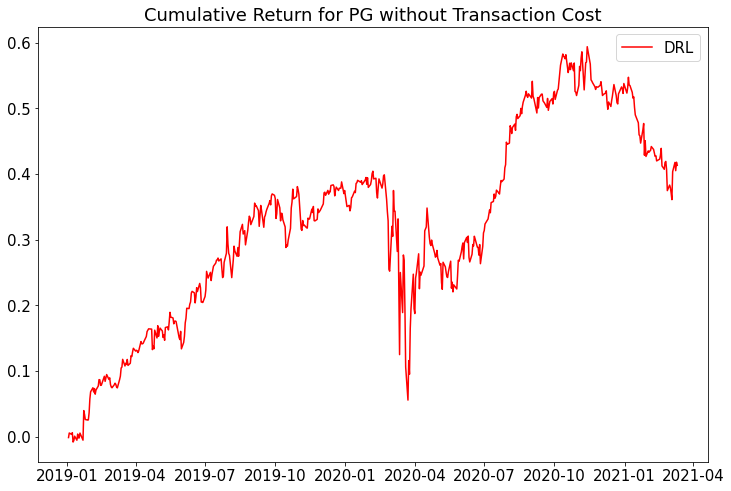

In [ ]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(12, 8))

plt.plot(test.datadate, DRL_cumulative_return, color='red',label = "DRL")
#plt.plot(test.datadate, test_cumulative_return, label = "test")
plt.title("Cumulative Return for PG without Transaction Cost",size= 18)
plt.legend()
plt.rc('legend',fontsize=15)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)